In [368]:
import pandas as pd
import yfinance
import numpy as np
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from datetime import date
import matplotlib
from scipy.signal import argrelextrema
from statsmodels.nonparametric.kernel_regression import KernelReg
from collections import defaultdict

In [369]:
stocksymbols = 'ITC.NS'
ticker = yfinance.Ticker(stocksymbols)
end = date.today()
start = "2020-01-01"
df = ticker.history(interval="1d",start=start,end=end)

In [370]:
df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)
df.index = pd.to_datetime(df.index, errors='coerce')
df.index = df.index.strftime('%d-%m-%y')
df = df.loc[:,['Close']]

In [371]:
def find_extrema(s, bw='cv_ls'):
    """
    Input:
        s: prices as pd.series
        bw: bandwith as str or array like
    Returns:
        prices: with 0-based index as pd.series
        extrema: extrema of prices as pd.series
        smoothed_prices: smoothed prices using kernel regression as pd.series
        smoothed_extrema: extrema of smoothed_prices as pd.series
    """
    # Copy series so we can replace index and perform non-parametric
    # kernel regression.
    prices = s.copy()
    prices = prices.reset_index()
    prices.columns = ['date', 'price']
    prices = prices['price']

    kr = KernelReg([prices.values], [prices.index.to_numpy()], var_type='c', bw=bw)
    f = kr.fit([prices.index])

    # Use smoothed prices to determine local minima and maxima
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    smooth_local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    smooth_local_min = argrelextrema(smooth_prices.values, np.less)[0]
    local_max_min = np.sort(np.concatenate([smooth_local_max, smooth_local_min]))
    smooth_extrema = smooth_prices.loc[local_max_min]

    # Iterate over extrema arrays returning datetime of passed
    # prices array. Uses idxmax and idxmin to window for local extrema.
    price_local_max_dt = []
    for i in smooth_local_max:
        if (i>1) and (i<len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].idxmax())

    price_local_min_dt = []
    for i in smooth_local_min:
        if (i>1) and (i<len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].idxmin())

    maxima = pd.Series(prices.loc[price_local_max_dt])
    minima = pd.Series(prices.loc[price_local_min_dt])
    extrema = pd.concat([maxima, minima]).sort_index()

    # Return series for each with bar as index
    return extrema, prices, smooth_extrema, smooth_prices

In [372]:
price = df['Close']
index = df.index
df1 = pd.DataFrame({'Price': price}, index=index)
df1.index.name = 'Date'
df1

,Price
Date,
01-01-20,202.353333
02-01-20,203.840607
03-01-20,202.693268
06-01-20,199.803726
07-01-20,200.016220
...,...
04-05-23,424.600006
05-05-23,428.750000
08-05-23,431.450012


In [373]:
extrema, price, smooth_extrema, smooth_prices = find_extrema(df1)


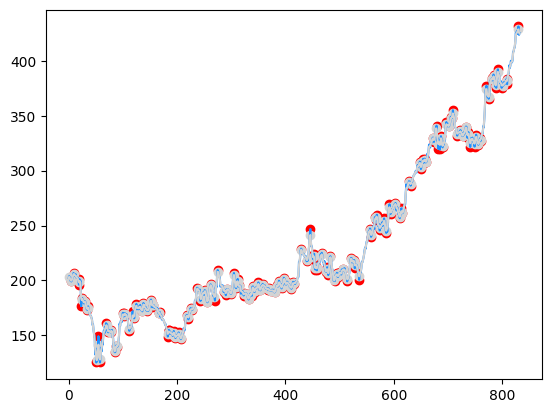

In [374]:
def plot_window(prices, extrema, smooth_prices, smooth_extrema, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    prices.plot(ax=ax, color='dodgerblue')
    ax.scatter(extrema.index, extrema.values, color='red')
    smooth_prices.plot(ax=ax, color='lightgrey')
    ax.scatter(smooth_extrema.index, smooth_extrema.values, color='lightgrey')
    plt.show()

plot_window(price, extrema, smooth_prices, smooth_extrema)

In [375]:
def find_patterns(s, max_bars=35):
    """
    Input:
        s: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        patterns: patterns as a defaultdict list of tuples
        containing the start and end bar of the pattern
    """
    patterns = defaultdict(list)

    # Need to start at five extrema for pattern generation
    for i in range(7, len(smooth_extrema)):
        window = smooth_extrema.iloc[i-7:i]

        # A pattern must play out within max_bars (default 35)
        if (window.index[-1] - window.index[0]) > max_bars:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]
        e6 = window.iloc[5]
        e7 = window.iloc[6]
        pattern_found = False  # set to True when a pattern is found
        # Head and Shoulders
        if  (e2 > e1) and (e2 > e3) and \
                (e4 < e1) and (e4 < e5) and \
                (e6 < e3) and (e6 < e5) and \
                (e2 - min(e1, e3) >= 0.03 * np.mean([e1, e3])) and \
                (max(e4, e6) - e5 <= 0.05 * np.mean([e4, e6])):
            patterns['Head_and_Shoulders'].append((window.index[0], window.index[-1]))
        # Inverse Head and Shoulders
        if (e2 < e1) and (e2 < e3) and \
                (e4 > e1) and (e4 > e5) and \
                (e6 > e3) and (e6 > e5) and \
                (max(e1, e3) - e2 >= 0.03 * np.mean([e1, e3])) and \
                (e5 - min(e4, e6) <= 0.05 * np.mean([e4, e6])):
            patterns['Inverse_Head_and_Shoulders'].append((window.index[0], window.index[-1]))

        # Bullish_Flag
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (e1 < e3) and (e2 < e3) and (e4 < e3) and (e5 < e3):
            patterns['Bullish_Flag'].append((window.index[0], window.index[-1]))

        # Bearish_Flag
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (e1 > e3) and (e2 > e3) and (e4 > e3) and (e5 > e3):
            patterns['Bearish_Flag'].append((window.index[0], window.index[-1]))

        # Bullish_Pennant
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (e1 < e2) and (e5 < e4) and (e2 < e3) and (e4 < e3):
            patterns['Bullish_Pennant'].append((window.index[0], window.index[-1]))

        # Bearish_Pennant
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (e1 > e2) and (e5 > e4) and (e2 > e3) and (e4 > e3):
            patterns['Bearish_Pennant'].append((window.index[0], window.index[-1]))

        # Ascending_Triangle
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (e1 < e3) and (e2 > e4) and (e5 < e3) and \
                (abs(e2 - e3) <= 0.03 * np.mean([e2, e3])) and \
                (abs(e4 - e3) <= 0.03 * np.mean([e3, e4])):
            patterns['Ascending_Triangle'].append((window.index[0], window.index[-1]))

        # Descending_Triangle
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (e1 > e3) and (e2 < e4) and (e5 > e3) and \
                (abs(e2 - e3) <= 0.03 * np.mean([e2, e3])) and \
                (abs(e4 - e3) <= 0.03 * np.mean([e3, e4])):
            patterns['Descending_Triangle'].append((window.index[0], window.index[-1]))

        # Bullish_Channel
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (e1 < e3) and (e5 > e3) and \
                (abs(e2 - e3) <= 0.03 * np.mean([e2, e3])) and \
                (abs(e4 - e3) <= 0.03 * np.mean([e3, e4])):
            patterns['Bullish_Channel'].append((window.index[0], window.index[-1]))

        # Bearish_Channel
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (e1 > e3) and (e5 < e3) and \
                (abs(e2 - e3) <= 0.03 * np.mean([e2, e3])) and \
                (abs(e4 - e3) <= 0.03 * np.mean([e3, e4])):
            patterns['Bearish_Channel'].append((window.index[0], window.index[-1]))

        # Horizontal_Channel
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e1 - e3) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e4 - e5) <= 0.03 * np.mean([e1, e3, e5])):
            patterns['Horizontal_Channel'].append((window.index[0], window.index[-1]))

        # Cup_with_Handle
        if (e1 < e2) and (e3 < e2) and (e4 < e2) and (e5 < e2) and \
                (abs(e1 - e3) <= 0.1 * np.mean([e1, e3, e5])) and \
                (abs(e4 - e2) <= 0.1 * np.mean([e1, e3, e5])) and \
                (abs(e5 - e2) <= 0.1 * np.mean([e1, e3, e5])) and \
                (abs(e1 - e5) <= 0.3 * np.mean([e1, e3, e5])) and \
                (e6 > np.mean([e1, e3, e5])) and (e7 > np.mean([e1, e3, e5])) and \
                (abs(e6 - e7) <= 0.1 * np.mean([e6, e7])):
            patterns['Cup_with_Handle'].append((window.index[0], window.index[-1]))

        # Symmetrical_Triangle
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e1 - e3) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e4 - e5) <= 0.03 * np.mean([e1, e3, e5])) and \
                ((e2 < e4 and e2 < e1 and e2 < e3 and e4 < e5) or \
                 (e2 > e4 and e2 > e1 and e2 > e3 and e4 > e5)):
            patterns['Symmetrical_Triangle'].append((window.index[0], window.index[-1]))

        # Rectangle
        if (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e1 - e3) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e4 - e5) <= 0.03 * np.mean([e1, e3, e5])) and \
                ((e2 < e4 and e2 < e1 and e5 > e3) or (e2 > e4 and e2 > e1 and e5 < e3)):
            patterns['Rectangle'].append((window.index[0], window.index[-1]))

        # Double_Top
        if (e2 > e1) and (e2 > e3) and (e4 > e3) and (e4 > e5) and \
                (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e1 - e3) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e4 - e5) <= 0.03 * np.mean([e1, e3, e5])):
            patterns['Double_Top'].append((window.index[0], window.index[-1]))

        # Double_Bottom
        if (e2 < e1) and (e2 < e3) and (e4 < e3) and (e4 < e5) and \
                (abs(e2 - e4) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e1 - e3) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e4 - e5) <= 0.03 * np.mean([e1, e3, e5])):
            patterns['Double_Bottom'].append((window.index[0], window.index[-1]))

        # Diamond_Top
        if (e2 < e1) and (e2 < e3) and (e4 < e3) and (e4 < e5) and \
                (abs(e2 - e4) >= 0.7 * np.mean([e1, e3, e5])) and \
                (abs(e1 - e3) <= 0.03 * np.mean([e1, e3, e5])) and \
                (abs(e4 - e5) <= 0.03 * np.mean([e1, e3, e5])):
            patterns['Diamond_Top'].append((window.index[0], window.index[-1]))

        # Falling_Wedge
        if (e2 > e1) and (e2 > e3) and (e4 > e3) and (e4 > e5) and \
                (e1 - e2 >= 0.15 * np.mean([e1, e3, e5])) and \
                (e1 - e2 <= 0.618 * (e1 - e3)) and \
                (e4 - e5 >= 0.15 * np.mean([e1, e3, e5])) and \
                (e4 - e5 <= 0.618 * (e1 - e3)):
            patterns['Falling_Wedge'].append((window.index[0], window.index[-1]))

        # Rising_Wedge
        if (e2 < e1) and (e2 < e3) and (e4 < e3) and (e4 < e5) and \
                (e2 - e1 >= 0.15 * np.mean([e1, e3, e5])) and \
                (e2 - e1 <= 0.618 * (e3 - e1)) and \
                (e5 - e4 >= 0.15 * np.mean([e1, e3, e5])) and \
                (e5 - e4 <= 0.618 * (e3 - e1)):
            patterns['Rising_Wedge'].append((window.index[0], window.index[-1]))

        # Rounding_Bottom
        if (e5 > e4) and (e4 > e3) and (e3 > e2) and (e2 > e1) and \
                (e1 < np.mean([e2, e5])) and (e5 - e1 >= 0.1 * np.mean([e1, e5])) and \
                (abs((e1 - np.min([e2, e3, e4, e5])) / (e5 - np.min([e2, e3, e4, e5]))) <= 0.15):
            patterns['Rounding_Bottom'].append((window.index[0], window.index[-1]))

        # Triple_Top
        if (e1 > e2) and (e2 < e3) and (e3 > e4) and (e4 < e5) and \
                (e1 - np.min([e2, e3, e4]) >= 0.05 * np.mean([e1, e2, e3, e4, e5])) and \
                (e1 - e2 <= 0.05 * np.mean([e1, e2, e3, e4, e5])) and \
                (e3 - e2 <= 0.05 * np.mean([e1, e2, e3, e4, e5])) and \
                (e3 - e4 <= 0.05 * np.mean([e1, e2, e3, e4, e5])):
            patterns['Triple_Top'].append((window.index[0], window.index[-1]))

        # Triple_Bottom
        if (e1 < e2) and (e2 > e3) and (e3 < e4) and (e4 > e5) and \
                (np.max([e2, e3, e4]) - e1 >= 0.05 * np.mean([e1, e2, e3, e4, e5])) and \
                (e2 - e1 <= 0.05 * np.mean([e1, e2, e3, e4, e5])) and \
                (e3 - e2 <= 0.05 * np.mean([e1, e2, e3, e4, e5])) and \
                (e4 - e3 <= 0.05 * np.mean([e1, e2, e3, e4, e5])):
            patterns['Triple_Bottom'].append((window.index[0], window.index[-1]))


    return patterns

In [376]:
a = find_patterns(df1)
a

defaultdict(list,
            {'Bullish_Flag': [(1, 25),
              (138, 167),
              (262, 293),
              (293, 315),
              (336, 350),
              (346, 369),
              (389, 414),
              (429, 456),
              (456, 483),
              (672, 687),
              (723, 744),
              (744, 770)],
             'Horizontal_Channel': [(1, 25),
              (135, 166),
              (138, 167),
              (183, 197),
              (185, 203),
              (186, 207),
              (187, 219),
              (192, 221),
              (238, 262),
              (287, 309),
              (305, 325),
              (323, 337),
              (325, 340),
              (326, 343),
              (337, 353),
              (340, 358),
              (343, 368),
              (346, 369),
              (347, 373),
              (350, 375),
              (353, 380),
              (358, 385),
              (368, 386),
              (369, 389),
             

In [377]:
pattern_ranking = {
 'Head_and_Shoulders': 1,
 'Bullish_Flag': 2,
 'Bearish_Flag': 2,
 'Ascending_Triangle': 3,
 'Descending_Triangle': 3,
 'Bullish_Channel': 4,
 'Bearish_Channel': 4,
 'Symmetrical_Triangle': 5,
 'Rectangle': 6,
 'Double_Top': 7,
 'Double_Bottom': 7,
 'Bullish_Pennant': 8,
 'Bearish_Pennant': 8,
 'Rounding_Bottom': 9,
 'Diamond_Top': 10,
 'Falling_Wedge': 11,
 'Rising_Wedge': 11,
 'Inverse_Head_and_Shoulders': 12,
 'Horizontal_Channel': 13,
 'Triple_Top': 14,
 'Triple_Bottom': 14,
 'Cup_with_Handle': 15
}

In [378]:
def get_best_pattern(patterns, pattern_ranking, df1):
    # create a dictionary to store the best pattern for each range
    best_patterns = {}

    # loop through the patterns
    for pattern, ranges in patterns.items():
        # loop through the ranges for this pattern
        for start, end in ranges:
            # if this is the first pattern for this range, add it to the dictionary
            if (start, end) not in best_patterns:
                # extract the start and end index values from df1 using iloc
                start_index = df1.iloc[start].name
                end_index = df1.iloc[end].name
                best_patterns[(start_index, end_index)] = (pattern, pattern_ranking[pattern])
            else:
                # if there is already a pattern for this range, compare the rankings
                current_ranking = pattern_ranking[best_patterns[(start, end)][0]]
                new_ranking = pattern_ranking[pattern]
                if new_ranking < current_ranking:
                    # if this pattern has a higher ranking, replace the current best pattern
                    # extract the start and end index values from df1 using iloc
                    start_index = df1.iloc[start].name
                    end_index = df1.iloc[end].name
                    best_patterns[(start_index, end_index)] = (pattern, new_ranking)

    # return a list of the best patterns for each range
    return [(pattern, start, end) for (start, end), (pattern, ranking) in best_patterns.items()]
b = get_best_pattern(a, pattern_ranking, df1)
b

[('Double_Bottom', '02-01-20', '05-02-20'),
 ('Symmetrical_Triangle', '23-07-20', '02-09-20'),
 ('Bullish_Flag', '18-01-21', '03-03-21'),
 ('Bullish_Flag', '03-03-21', '07-04-21'),
 ('Bullish_Flag', '10-05-21', '31-05-21'),
 ('Ascending_Triangle', '25-05-21', '25-06-21'),
 ('Symmetrical_Triangle', '26-07-21', '31-08-21'),
 ('Bullish_Flag', '22-09-21', '01-11-21'),
 ('Bullish_Flag', '01-11-21', '10-12-21'),
 ('Double_Bottom', '14-09-22', '06-10-22'),
 ('Symmetrical_Triangle', '29-11-22', '28-12-22'),
 ('Ascending_Triangle', '28-12-22', '03-02-23'),
 ('Triple_Bottom', '20-07-20', '01-09-20'),
 ('Rectangle', '24-09-20', '15-10-20'),
 ('Bearish_Channel', '28-09-20', '23-10-20'),
 ('Rectangle', '29-09-20', '29-10-20'),
 ('Bearish_Channel', '30-09-20', '14-11-20'),
 ('Rectangle', '08-10-20', '18-11-20'),
 ('Descending_Triangle', '14-12-20', '18-01-21'),
 ('Double_Top', '23-02-21', '26-03-21'),
 ('Symmetrical_Triangle', '22-03-21', '23-04-21'),
 ('Rectangle', '20-04-21', '11-05-21'),
 ('Beari

In [379]:
def head_and_shoulders(df):

    # Find the highest high and lowest low in the first and third peaks
    first_peak_high = df.iloc[:df.shape[0]//3]['Close'].max()
    first_peak_low = df.iloc[:df.shape[0]//3]['Close'].min()
    third_peak_high = df.iloc[df.shape[0]//3*2:]['Close'].max()
    third_peak_low = df.iloc[df.shape[0]//3*2:]['Close'].min()

    # Find the neckline by connecting the lows of the first and third peaks
    neckline = df[(df['Close'] == first_peak_low) | (df['Close'] == third_peak_low)]

    # Find the distance between the neckline and the highest high of the pattern
    distance = abs(first_peak_high - neckline.iloc[0]['Close'])

    # Calculate the target and stoploss levels
    target = third_peak_low - distance
    stoploss = first_peak_high

    return target, stoploss

In [380]:
def bullish_flag(df):
    # Calculate the flagpole height
    flagpole = df['Close'].max() - df['Close'].min()

    # Calculate the breakout level
    breakout = df['Close'].max()

    # Calculate the target level
    target = breakout + flagpole

    # Calculate the stop-loss level
    stop_loss = df['Close'].min()

    # Return the target and stop-loss levels
    return target, stop_loss

In [381]:
def bearish_flag(df):
    # Calculate the flagpole height
    flagpole = df['Close'].max() - df['Close'].min()

    # Calculate the breakout level
    breakout = df['Close'].min()

    # Calculate the target level
    target = breakout - flagpole

    # Calculate the stop-loss level
    stop_loss = df['Close'].max()

    # Return the target and stop-loss levels
    return target, stop_loss


In [382]:
def ascending_triangle(df):
    # Calculate the support and resistance levels
    support = df['Close'].max()
    resistance = df['Close'].min()

    # Calculate the pattern height
    pattern_height = support - resistance

    # Calculate the target level
    target = resistance + pattern_height

    # Calculate the stop-loss level
    stop_loss = support - pattern_height

    # Return the target and stop-loss levels
    return target, stop_loss


In [383]:
def descending_triangle(df):
    # Calculate the support and resistance levels
    support = df['Close'].min()
    resistance = df['Close'].min()

    # Calculate the pattern height
    pattern_height = resistance - support

    # Calculate the target level
    target = support - pattern_height

    # Calculate the stop-loss level
    stop_loss = resistance + pattern_height

    # Return the target and stop-loss levels
    return target, stop_loss

In [384]:
def bullish_channel(df):
    # Find the highest high and lowest low in the first and second touches
    first_touch_high = df.iloc[:df.shape[0]//2]['Close'].max()
    first_touch_low = df.iloc[:df.shape[0]//2]['Close'].min()
    second_touch_high = df.iloc[df.shape[0]//2:]['Close'].max()
    second_touch_low = df.iloc[df.shape[0]//2:]['Close'].min()

    # Find the slope of the channel
    slope = (second_touch_high - first_touch_high) / (df.shape[0]//2)

    # Find the distance between the first touch and the channel
    distance = abs(first_touch_high - first_touch_low)

    # Calculate the target and stoploss levels
    target = second_touch_high + distance
    stoploss = first_touch_low - distance

    return target, stoploss

In [385]:
def bearish_channel(df):
    # Find the highest high and lowest low in the first and second touches
    first_touch_high = df.iloc[:df.shape[0]//2]['Close'].max()
    first_touch_low = df.iloc[:df.shape[0]//2]['Close'].min()
    second_touch_high = df.iloc[df.shape[0]//2:]['Close'].max()
    second_touch_low = df.iloc[df.shape[0]//2:]['Close'].min()

    # Find the slope of the channel
    slope = (second_touch_low - first_touch_low) / (df.shape[0]//2)

    # Find the distance between the first touch and the channel
    distance = abs(first_touch_high - first_touch_low)

    # Calculate the target and stoploss levels
    target = second_touch_low - distance
    stoploss = first_touch_high + distance

    return target, stoploss

In [386]:
def symmetrical_triangle(df):
    # Find the highest high and lowest low in the first and second touches
    first_touch_high = df.iloc[:df.shape[0]//2]['Close'].max()
    first_touch_low = df.iloc[:df.shape[0]//2]['Close'].min()
    second_touch_high = df.iloc[df.shape[0]//2:]['Close'].max()
    second_touch_low = df.iloc[df.shape[0]//2:]['Close'].min()

    # Find the distance between the first touch and the apex of the triangle
    distance = abs(first_touch_high - first_touch_low)

    # Calculate the target and stoploss levels
    if first_touch_high < second_touch_high:
        target = second_touch_high + distance
        stoploss = first_touch_low - distance
    else:
        target = second_touch_low - distance
        stoploss = first_touch_high + distance

    return target, stoploss

In [387]:
def rectangle(df):
    # Find the highest high and lowest low in the range
    high = df['Close'].max()
    low = df['Close'].min()

    # Find the distance between the high and the low
    distance = abs(high - low)

    # Calculate the target and stoploss levels
    target = high + distance
    stoploss = low - distance

    return target, stoploss

In [388]:
def double_top(df):
    # Find the highest high in the first and second tops
    first_top_high = df.iloc[:df.shape[0]//2]['Close'].max()
    second_top_high = df.iloc[df.shape[0]//2:]['Close'].max()

    # Find the lowest low in the valley
    valley_low = df.iloc[df.shape[0]//4:3*df.shape[0]//4]['Close'].min()

    # Find the distance between the valley and the first top
    distance = abs(first_top_high - valley_low)

    # Calculate the target and stoploss levels
    target = second_top_high + distance
    stoploss = valley_low - distance

    return target, stoploss

In [389]:
def double_bottom(df):
    # Find the lowest low in the first and second bottoms
    first_bottom_low = df.iloc[:df.shape[0]//2]['Close'].min()
    second_bottom_low = df.iloc[df.shape[0]//2:]['Close'].min()

    # Find the highest high in the valley
    valley_high = df.iloc[df.shape[0]//4:3*df.shape[0]//4]['Close'].max()

    # Find the distance between the valley and the first bottom
    distance = abs(first_bottom_low - valley_high)

    # Calculate the target and stoploss levels
    target = second_bottom_low - distance
    stoploss = valley_high + distance

    return target, stoploss

In [390]:
def bullish_pennant(df):
    # Calculate the height of the pennant flagpole
    flagpole_height = df["Close"].iloc[-1] - df["Close"].iloc[0]

    # Calculate the breakout level (i.e., the top of the pennant)
    breakout_level = df["Close"].max()

    # Calculate the target level
    target = breakout_level + flagpole_height

    # Calculate the stop loss level (i.e., the bottom of the pennant)
    stop_loss = df["Close"].min()

    return (target, stop_loss)

In [391]:
def bearish_pennant(df):
    # Calculate the height of the pennant flagpole
    flagpole_height = df["Close"].iloc[-1] - df["Close"].iloc[0]

    # Calculate the breakout level (i.e., the top of the pennant)
    breakout_level = df["Close"].max()

    # Calculate the target level
    target = breakout_level - flagpole_height

    # Calculate the stop loss level (i.e., the bottom of the pennant)
    stop_loss = df["Close"].max()

    return (target, stop_loss)

In [392]:
def rounding_bottom(df):
    # Calculate the minimum price and its index
    min_price = df['Close'].min()
    min_idx = df['Close'].idxmin()

    # Calculate the left and right sides of the pattern
    left_side = df.loc[:min_idx, 'Close']
    right_side = df.loc[min_idx:, 'Close']

    # Calculate the resistance level
    resistance = min_price + (left_side.max() - min_price) * 0.5

    # Calculate the target and stoploss levels
    target = resistance + (resistance - min_price)
    stoploss = min_price - (left_side.max() - min_price)

    return target, stoploss

In [393]:
def diamond_top(df):
    # Calculate the length of the pattern
    length = len(df)

    # Calculate the midpoint index
    midpoint = length // 2

    # Calculate the left and right sides of the pattern
    left_side = df.iloc[:midpoint, df.columns.get_loc('Close')]
    right_side = df.iloc[midpoint:, df.columns.get_loc('Close')]

    # Calculate the resistance and support levels
    resistance = left_side.max()
    support = right_side.min()

    # Calculate the target and stoploss levels
    target = support - (resistance - support)
    stoploss = resistance + (resistance - support)

    return target, stoploss

In [394]:
def falling_wedge(df):
    # Calculate the length of the pattern
    length = len(df)

    # Calculate the midpoint index
    midpoint = length // 2

    # Calculate the left and right sides of the pattern
    left_side = df.loc[:df.index[midpoint], 'Close']
    right_side = df.loc[df.index[midpoint]:, 'Close']

    # Calculate the resistance and support trendlines
    resistance = left_side.max()
    support = right_side.min()

    # Calculate the target and stoploss levels
    target = resistance - (resistance - support) * 2
    stoploss = support - (resistance - support) * 0.5

    return target, stoploss

In [395]:
def rising_wedge(df):
    # Calculate the length of the pattern
    length = len(df)

    # Calculate the midpoint index
    midpoint = length // 2

    # Calculate the left and right sides of the pattern
    left_side = df.loc[:df.index[midpoint], 'Close']
    right_side = df.loc[df.index[midpoint]:, 'Close']

    # Calculate the resistance and support trendlines
    resistance = right_side.min()
    support = left_side.max()

    # Calculate the target and stoploss levels
    target = support - (resistance - support) * 0.5
    stoploss = resistance - (resistance - support) * 2

    return target, stoploss

In [396]:
def Inverse_Head_and_Shoulders(df):
    # Find the lowest price in the left shoulder
    left_shoulder_low = df.iloc[:round(len(df)/3)]['Close'].min()

    # Find the lowest price in the head
    head_low = df.iloc[round(len(df)/3):round(len(df)*2/3)]['Close'].min()

    # Find the lowest price in the right shoulder
    right_shoulder_low = df.iloc[round(len(df)*2/3):]['Close'].min()

    # Calculate the target price as the distance from the head to the neckline, added to the neckline
    target_price = head_low + (head_low - left_shoulder_low)

    # Calculate the stop loss as the distance from the head to the neckline, subtracted from the neckline
    stop_loss = right_shoulder_low - (head_low - left_shoulder_low)

    return target_price, stop_loss

In [397]:
def Horizontal_Channel(df):
    # Find the highest and lowest prices in the channel
    channel_high = df['Close'].max()
    channel_low = df['Close'].min()

    # Calculate the target price as the distance from the channel high to the channel low, added to the channel high
    target_price = channel_high + (channel_high - channel_low)

    # Calculate the stop loss as the distance from the channel high to the channel low, subtracted from the channel low
    stop_loss = channel_low - (channel_high - channel_low)

    return (target_price, stop_loss)

In [398]:
def Triple_Top(df):
    # Find the highest price in the first top
    first_top_high = df.iloc[:round(len(df)/3)]['Close'].max()

    # Find the highest price in the second top
    second_top_high = df.iloc[round(len(df)/3):round(len(df)*2/3)]['Close'].max()

    # Find the highest price in the third top
    third_top_high = df.iloc[round(len(df)*2/3):]['Close'].max()

    # Calculate the target price as the distance from the triple top high to the neckline, subtracted from the neckline
    target_price = df.iloc[round(len(df)*2/3):]['Close'].min() - (third_top_high - df.iloc[round(len(df)*2/3):]['Close'].min())

    # Calculate the stop loss as the distance from the first top high to the neckline, added to the neckline
    stop_loss = df.iloc[:round(len(df)/3)]['Close'].min() + (first_top_high - df.iloc[:round(len(df)/3)]['Close'].min())

    return (target_price, stop_loss)

In [399]:
def Triple_Bottom(df):
    # Find the lowest price in the first bottom
    first_bottom_low = df.iloc[:round(len(df)/3)]['Close'].min()

    # Find the lowest price in the second bottom
    second_bottom_low = df.iloc[round(len(df)/3):round(len(df)*2/3)]['Close'].min()

    # Find the lowest price in the third bottom
    third_bottom_low = df.iloc[round(len(df)*2/3):]['Close'].min()

    # Calculate the target price as the distance from the triple bottom low to the neckline, added to the neckline
    target_price = df.iloc[round(len(df)*2/3):]['Close'].max() + (df.iloc[round(len(df)*2/3):]['Close'].max() - third_bottom_low)

    # Calculate the stop loss as the distance from the first bottom low to the neckline, subtracted from the neckline
    stop_loss = df.iloc[:round(len(df)/3)]['Close'].max() - (first_bottom_low - df.iloc[:round(len(df)/3)]['Close'].max())

    return (target_price, stop_loss)

In [400]:
def Cup_with_Handle(df):
    # Find the highest price in the cup
    cup_high = df.iloc[:round(len(df)*0.7)]['Close'].max()

    # Find the lowest price in the handle
    handle_low = df.iloc[round(len(df)*0.7):]['Close'].min()

    # Calculate the target price as the distance from the cup high to the breakout point, added to the breakout point
    target_price = handle_low + (cup_high - handle_low)

    # Calculate the stop loss as the distance from the cup high to the handle low, subtracted from the handle low
    stop_loss = handle_low - (cup_high - handle_low)

    return (target_price, stop_loss)

In [401]:
def calculate_target_stoploss(patterns):
    result = []
    for pattern in patterns:
        name, start, end = pattern

        df2 = df.loc[start:end].copy()
        df2.index = pd.to_datetime(df2.index)
        # Convert the 'Close' column to a numeric data type using .loc
        df2['Close'] = pd.to_numeric(df2['Close'], errors='coerce')

        # Calculate the target and stop loss for the Bullish Flag pattern
        target, stop_loss = Cup_with_Handle(df)

        if name == 'Head_and_Shoulders':
            target,stop_loss = head_and_shoulders(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Bullish_Flag':
            target,stop_loss = bullish_flag(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Bearish_Flag':
            target,stop_loss = bearish_flag(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Ascending_Triangle':
            target,stop_loss = ascending_triangle(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Descending_Triangle':
            target,stop_loss = descending_triangle(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Bullish_Channel':
            target,stop_loss = bullish_channel(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Bearish_Channel' :
            target,stop_loss = bearish_channel(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Symmetrical_Triangle':
            target,stop_loss = symmetrical_triangle(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Rectangle':
            target,stop_loss = rectangle(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Double_Top' :
            target,stop_loss = double_top(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Double_Bottom':
            target,stop_loss = double_bottom(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Bullish_Pennant' :
            target,stop_loss = bullish_pennant(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Bearish_Pennant':
            target,stop_loss = bearish_pennant(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Rounding_Bottom' :
            target,stop_loss = rounding_bottom(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Diamond_Top':
            target,stop_loss = diamond_top(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Falling_Wedge' :
            target,stop_loss = falling_wedge(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Rising_Wedge' :
            target,stop_loss = rising_wedge(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Inverse_Head_and_Shoulders' :
            target,stop_loss = Inverse_Head_and_Shoulders(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Horizontal_Channel' :
            target,stop_loss = Horizontal_Channel(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Triple_Top':
            target,stop_loss = Triple_Top(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Triple_Bottom' :
            target,stop_loss = Triple_Bottom(df2)
            result.append((name, start,end,target, stop_loss))

        elif name == 'Cup_with_Handle':
            target,stop_loss = Cup_with_Handle(df2)
            result.append((name, start,end,target, stop_loss))



        else:
            # For other patterns, set the target and stop loss to None
            target = None
            stop_loss = None
            result.append((name, start,end,target, stop_loss))

        # Add a check to make sure that target and stop_loss are not None

        #result.append((name, start,end,target, stop_loss))


    return pd.DataFrame(result, columns=['Pattern', 'formation_date','breakout_date','Target', 'Stop Loss'])

In [402]:
c =  calculate_target_stoploss(b)
print(c)


                 Pattern formation_date breakout_date      Target   Stop Loss
0          Double_Bottom       02-01-20      05-02-20  168.741089  214.421478
1   Symmetrical_Triangle       23-07-20      02-09-20  159.590836  192.831543
2           Bullish_Flag       18-01-21      03-03-21  237.197052  181.617249
3           Bullish_Flag       03-03-21      07-04-21  225.759155  187.705750
4           Bullish_Flag       10-05-21      31-05-21  210.345673  185.921997
..                   ...            ...           ...         ...         ...
79       Bullish_Channel       14-07-22      25-08-22  329.798828  267.530823
80       Bullish_Channel       18-08-22      22-09-22  356.281128  290.567535
81       Bullish_Channel       29-09-22      03-11-22  361.203522  307.303558
82       Bullish_Channel       11-10-22      21-11-22  378.136505  298.197174
83       Bullish_Channel       20-02-23      31-03-23  400.500000  358.699982

[84 rows x 5 columns]
